**Table of contents**<a id='toc0_'></a>

- [Importing Libraries](#toc1_)
- [Configuring Visualization Parameters](#toc2_)
- [Configuring Other Notebook Parameters](#toc3_)
- [Pre-installing Custom Functions](#toc4_)
- [Practicing in Stages](#toc5_)
  - [Preprocessing](#toc5_1_)
    - [Preprocessing of the Original Training Dataset Labels](#toc5_1_1_)
    - [Reading and Effective Storage of DICOM Files](#toc5_1_2_)
  - [Train - Part One - Data Loading](#toc5_2_)
    - [Data Transformation](#toc5_2_1_)
    - [Visualization of Data Transformation](#toc5_2_2_)
    - [Batch Loading](#toc5_2_3_)
  - [Train - Part Two - Model Creation](#toc5_3_)

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->


# <a id='toc1_'></a>[Importing Libraries](#toc0_)


In [1]:
import pydicom

In [2]:
#
import pytorch_lightning as pl

#
from pytorch_lightning.callbacks import ModelCheckpoint

#
from pytorch_lightning.loggers import TensorBoardLogger

In [3]:
import pandas as pd

import torch
from torch.utils.data import DataLoader

#
import torchmetrics

# models
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid

In [4]:
import cv2

import matplotlib as mpl
import matplotlib.pyplot as plt

In [5]:
from functools import wraps
import itertools
import math
from pathlib import Path
import reprlib
import sys
from tqdm.notebook import tqdm

# <a id='toc2_'></a>[Configuring Visualization Parameters](#toc0_)


In [6]:
%matplotlib inline

In [7]:
XINHUI = "#7a7374"
XUEBAI = "#fffef9"
YINBAI = "#f1f0ed"
YINHUI = "#918072"

figure_size = (16, 9)

In [8]:
custom_params = {
    "axes.axisbelow": True,
    "axes.edgecolor": YINBAI,
    "axes.facecolor": XUEBAI,
    "axes.grid": True,
    "axes.labelcolor": XINHUI,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.titlecolor": XINHUI,
    "figure.edgecolor": YINBAI,
    "figure.facecolor": XUEBAI,
    "grid.alpha": 0.8,
    "grid.color": YINBAI,
    "grid.linestyle": "--",
    "grid.linewidth": 1.2,
    "legend.edgecolor": YINHUI,
    "patch.edgecolor": XUEBAI,
    "patch.force_edgecolor": True,
    "text.color": XINHUI,
    "xtick.color": YINHUI,
    "ytick.color": YINHUI,
}

mpl.rcParams.update(custom_params)

# <a id='toc3_'></a>[Configuring Other Notebook Parameters](#toc0_)


In [9]:
reprlib_rules = reprlib.Repr()
reprlib_rules.maxother = 250

# <a id='toc4_'></a>[Pre-installing Custom Functions](#toc0_)


In [10]:
sys.path.append("../")

In [11]:
from Modules import *

# <a id='toc5_'></a>[Practicing in Stages](#toc0_)

## <a id='toc5_1_'></a>[Preprocessing](#toc0_)

### <a id='toc5_1_1_'></a>[Preprocessing of the Original Training Dataset Labels](#toc0_)


In [12]:
# The dataset used in this practice project is the publicly available chest X-ray dataset 
# (https://nihcc.app.box.com/v/ChestXray-NIHCC) from the National Institutes of Health (NIH) 
# Clinical Center (https://clinicalcenter.nih.gov/), and the related NIH press release can be 
# found at the following link: https://www.nih.gov/news-events/news-releases/nih-clinical
# -center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community
#
# References:
# [1] X. Wang, Y. Peng, L. Lu, Z. Lu, M. Bagheri and R. M. Summers, "ChestX-Ray8:
# Hospital-Scale Chest X-Ray Database and Benchmarks on Weakly-Supervised Classification and
# Localization of Common Thorax Diseases," 2017 IEEE Conference on Computer Vision and Pattern
# Recognition (CVPR), Honolulu, HI, USA, 2017, pp. 3462-3471, doi: 10.1109/CVPR.2017.369.
#
# This article is publicly available through the following links, among others:
# http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest
# _CVPR_2017_paper.pdf or https://arxiv.org/pdf/1705.02315.pdf
#
# The dataset, provided by Kaggel Datasets, is called RSNA Pneumonia Detection Challenge
# (https://www.kaggle.com/competitions/rsna-pneumonia-detection-challenge) and was developed
# in collaboration with the Radiological Society of North America (RSNA®), the US National
# Institutes of Health, the Society of Thoracic Radiology, and MD.ai
original_labels = pd.read_csv(
    "../Datasets/Kaggle - RSNA Pneumonia Detection Challenge/stage_2_train_labels.csv"
)

# Positive targets indicated that these subjects suffered from pneumonia, with more
# positive targets indicating a more significant condition
grouped_labels = pd.DataFrame(
    original_labels.groupby(["patientId"])["Target"].sum()
).reset_index()

most_tagged_IDs = grouped_labels.loc[
    grouped_labels["Target"] == grouped_labels["Target"].max()
]

dataframe_1 = DataFrame_Generator(original_labels.columns.to_list())
for i in range(10):
    dataframe_1.updater(original_labels.iloc[i].to_list())

dataframe_2 = DataFrame_Generator(grouped_labels.columns.to_list())
for i in range(10):
    dataframe_2.updater(grouped_labels.iloc[i].to_list())

dataframe_3 = DataFrame_Generator(most_tagged_IDs.columns.to_list())
for i in range(len(most_tagged_IDs)):
    dataframe_3.updater(most_tagged_IDs.iloc[i].to_list())

tabulation = Form_Generator()
tabulation.heading_printer("Readings of the original training dataset labels")

statements = [
    """
original_labels = pd.read_csv(
    "../Datasets/Kaggle - RSNA Pneumonia Detection Challenge/stage_2_train_labels.csv"
)

grouped_labels = pd.DataFrame(
    original_labels.groupby(["patientId"])["Target"].sum()
).reset_index()

most_tagged_IDs = grouped_labels.loc[
    grouped_labels["Target"] == grouped_labels["Target"].max()
]
"""
]
tabulation.statement_generator(statements)

expressions = ['grouped_labels["Target"].max()', "len(most_tagged_IDs)"]
results = [str(grouped_labels["Target"].max()), str(len(most_tagged_IDs))]
tabulation.expression_generator(expressions, results)

df_table_1 = dataframe_1.tabulation()
tabulation.dataframe_generator(df_table_1)

df_table_2 = dataframe_2.tabulation()
tabulation.dataframe_generator(df_table_2)

df_table_3 = dataframe_3.tabulation()
tabulation.dataframe_generator(df_table_3)

Readings of the original training dataset labels

    +------------------------------------------------------------+
    | Statement                                                  |
    +------------------------------------------------------------+
    | original_labels = pd.read_csv(                             |
    |     "../Datasets/Kaggle - RSNA Pneumonia Detection         |
    |     Challenge/stage_2_train_labels.csv"                    |
    | )                                                          |
    |                                                            |
    | grouped_labels = pd.DataFrame(                             |
    |     original_labels.groupby(["patientId"])["Target"].sum() |
    | ).reset_index()                                            |
    |                                                            |
    | most_tagged_IDs = grouped_labels.loc[                      |
    |     grouped_labels["Target"] ==                            |
    |     gr

In [13]:
# `DataFrame.drop_duplicates` returns the DataFrame from which duplicate rows have been removed
labels = original_labels.drop_duplicates("patientId")

dataframe = DataFrame_Generator(labels.columns.to_list())

for i in range(10):
    dataframe.updater(labels.iloc[i].to_list())

tabulation = Form_Generator()
tabulation.heading_printer("Removal of the original duplicate training dataset labels")

statements = ['labels = labels.drop_duplicates("patientId")']
tabulation.statement_generator(statements)

expressions = ["len(labels)"]
results = [str(len(labels))]
tabulation.expression_generator(expressions, results)

df_table = dataframe.tabulation()
tabulation.dataframe_generator(df_table)

Removal of the original duplicate training dataset labels

    +----------------------------------------------+
    | Statement                                    |
    +----------------------------------------------+
    | labels = labels.drop_duplicates("patientId") |
    +----------------------------------------------+
    +-------------+--------+
    | Expression  | Result |
    +-------------+--------+
    | len(labels) | 26684  |
    +-------------+--------+
    +----+--------------------------------------+-----+-----+
    |    | patientId                            |   x |   y |
    |----+--------------------------------------+-----+-----+
    |  0 | 0004cfab-14fd-4e49-80ba-63a80b6bddd6 | nan | nan |
    |  1 | 00313ee0-9eaa-42f4-b0ab-c148ed3241cd | nan | nan |
    |  2 | 00322d4d-1c29-4943-afc9-b6754be640eb | nan | nan |
    |  3 | 003d8fa0-6bf1-40ed-b54c-ac657f8495c5 | nan | nan |
    |  4 | 00436515-870c-4b36-a041-de91049b9ab4 | 264 | 152 |
    |  5 | 00569f44-917d-4c86-a842-

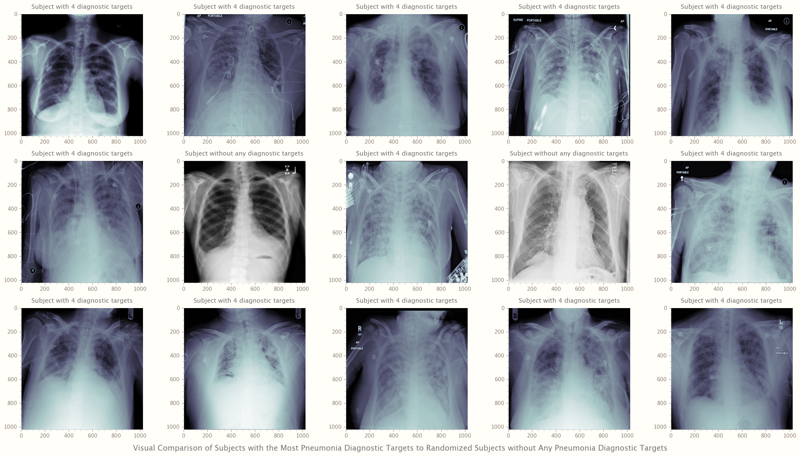

In [14]:
def image_display(image, ax, title, cmap):
    ax.imshow(image, cmap)
    ax.grid(False)
    ax.set_title(title, loc="center", pad=10)
    x_ticks = list(range(0, image.shape[1], 200))
    y_ticks = list(range(0, image.shape[0], 200))
    ax.set(xticks=x_ticks, xticklabels=x_ticks, yticks=y_ticks, yticklabels=y_ticks)
    ax.set_xlim(left=0)
    ax.set_ylim(top=0)
    ax.minorticks_on()
    return ax


ROOT_PATH = Path(
    "../Datasets/Kaggle - RSNA Pneumonia Detection Challenge/stage_2_train_images/"
)

fig, axs = plt.subplots(3, 5, figsize=(figure_size[0] / 3 * 4, figure_size[1] / 3 * 4))

c = 0
for i, ax in enumerate(axs.flat):
    untargeted = iter(labels.loc[labels["Target"] == 0].sample(2)["patientId"])
    if i not in [6, 8]:
        patient_id = most_tagged_IDs.patientId.iloc[c]
        dcm_path = ROOT_PATH / patient_id
        # `PurePath.with_suffix` returns the new path with the changed suffix
        #
        # Note that if the original path does not have a suffix, the new suffix is added;
        # if the suffix is an empty string, the original suffix is removed
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.read_file(dcm_path).pixel_array
        targets = most_tagged_IDs["Target"].iloc[c]
        title = f"Subject with {targets} diagnostic targets"
        image_display(dcm, ax, title, "bone")
        c += 1
    else:
        patient_id = next(untargeted)
        dcm_path = ROOT_PATH / patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.read_file(dcm_path).pixel_array
        title = "Subject without any diagnostic targets"
        image_display(dcm, ax, title, "gray")

fig.suptitle(
    "Visual Comparison of Subjects with the Most Pneumonia Diagnostic Targets to "
    "Randomized Subjects without Any Pneumonia Diagnostic Targets",
    fontsize="x-large",
    x=0.5,
    y=0,
)

plt.tight_layout()
plt.show()

### <a id='toc5_1_2_'></a>[Reading and Effective Storage of DICOM Files](#toc0_)


In [15]:
SAVE_PATH = Path("processed/")

sums = 0
sums_squared = 0

for c, patient_id in enumerate(tqdm(labels.patientId)):
    dcm_path = ROOT_PATH / patient_id
    dcm_path = dcm_path.with_suffix(".dcm")
    # Bits Stored (0028,0101) indicates number of bits stored for each pixel sample,
    # noting that each sample shall have the same number of bits stored
    bits_stored = pydicom.read_file(dcm_path).BitsStored
    dcm = pydicom.read_file(dcm_path).pixel_array / (np.power(2, bits_stored) - 1)
    # Resize the original image to 224 x 224 to reduce the processing load on the deep learning
    # model
    #
    # When storing an image, it is converted to float16 to reduce the amount of space used
    # because, in computing, half-precision (sometimes referred to as FP16 or float16) is a
    # binary floating-point computer number format that takes up two bytes in computer memory
    # and is used to represent numbers in small amounts of storage space and with low accuracy
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)
    normalizer = dcm_array.shape[0] * dcm_array.shape[1]

    # Retrieve the corresponding label for each image
    label = labels.Target.iloc[c]
    # Split the original training dataset into a processed training dataset and a processed
    # validation dataset
    train_or_val = "train" if c < 24000 else "val"
    # Divide each of the two processed datasets into labeled subsets based on the labels
    current_save_path = ROOT_PATH / SAVE_PATH / train_or_val / str(label)
    # `Path.mkdir` will create a new directory under the given path with two frequently used
    # parameters `parents` and `exists_ok`
    #
    # If `parents` is True, missing parents for the path are created as needed; however, if
    # `parents` is False (the default is False), the missing parent raises `FileNotFoundError`
    # exception
    #
    # If `exist_ok` is False (the default is False), the `FileExistsError` exception is thrown
    # if the destination directory already exists; if `exist_ok` is True, the `FileExistsError`
    # exception is ignored if the last path component is not an existing non-directory file
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(file=current_save_path / patient_id, arr=dcm_array)

    # Calculate dataset statistics using only the processed training dataset
    if train_or_val == "train":
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (np.power(dcm_array, 2).sum()) / normalizer

mean = sums / 24000
std = np.sqrt(sums_squared / 24000 - (mean**2))

tabulation = Form_Generator()
tabulation.heading_printer(
    "Effective storing of DICOM files and calculating of statistics"
)

statements = [
    """
SAVE_PATH = Path("processed/")

sums = 0
sums_squared = 0

for c, patient_id in enumerate(tqdm(labels.patientId)):
    dcm_path = ROOT_PATH / patient_id
    dcm_path = dcm_path.with_suffix(".dcm")
    bits_stored = pydicom.read_file(dcm_path).BitsStored
    dcm = pydicom.read_file(dcm_path).pixel_array / (np.power(2, bits_stored) - 1)
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)
    normalizer = dcm_array.shape[0] * dcm_array.shape[1]

    label = labels.Target.iloc[c]
    train_or_val = "train" if c < 24000 else "val"
    current_save_path = ROOT_PATH / SAVE_PATH / train_or_val / str(label)
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(file=current_save_path / patient_id, arr=dcm_array)

    if train_or_val == "train":
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (np.power(dcm_array, 2).sum()) / normalizer

mean = sums / 24000
std = np.sqrt(sums_squared / 24000 - (mean**2))
"""
]
tabulation.statement_generator(statements)

variables = ["bits_stored", "normalizer", "sums", "sums_squared", "mean", "std"]
values = [
    str(bits_stored),
    str(normalizer),
    str(sums),
    str(sums_squared),
    str(mean),
    str(std),
]
tabulation.variable_generator(variables, values)

  0%|          | 0/26684 [00:00<?, ?it/s]

Effective storing of DICOM files and calculating of statistics

    +----------------------------------------------------------+
    | Statement                                                |
    +----------------------------------------------------------+
    | SAVE_PATH = Path("processed/")                           |
    |                                                          |
    | sums = 0                                                 |
    | sums_squared = 0                                         |
    |                                                          |
    | for c, patient_id in enumerate(tqdm(labels.patientId)):  |
    |     dcm_path = ROOT_PATH / patient_id                    |
    |     dcm_path = dcm_path.with_suffix(".dcm")              |
    |     bits_stored = pydicom.read_file(dcm_path).BitsStored |
    |     dcm = pydicom.read_file(dcm_path).pixel_array /      |
    |     (np.power(2, bits_stored) - 1)                       |
    |     dcm_array = cv2.

## <a id='toc5_2_'></a>[Train - Part One - Data Loading](#toc0_)

### <a id='toc5_2_1_'></a>[Data Transformation](#toc0_)


In [16]:
# `transforms.Compose` composes several transforms together
train_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        # `transforms.Normalize` normalizes the tensor image with mean and standard deviation
        transforms.Normalize(mean, std),
        # Data augmentation is a technique that increases the amount of data used to
        # train a model
        #
        # In order to make reliable predictions, deep learning models usually require a large
        # amount of training data, which is not always available, so existing data needs to be
        # augmented to build better generalized models
        #
        # The most commonly used image data augmentation techniques include position
        # augmentation (e.g., scaling, cropping, flipping, padding, rotating, translation,
        # affine transformation) and color augmentation (e.g., brightness, contrast,
        # saturation, hue)
        #
        # `transforms.RandomAffine` sets the random affine transformation of the image,
        # keeping the center invariant
        #
        # The `degrees` parameter indicates the range of degrees to be selected, note that
        # if it is a number and not a sequence like (min, max), the range of degrees will be
        # between its positive and negative absolute values, if it is set to 0, it means that
        # the rotation is deactivated
        #
        # The `translate` parameter indicates the maximum absolute fraction tuple for
        # horizontal and vertical translation, and the `scale` parameter indicates
        # the scaling factor interval
        transforms.RandomAffine(degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
        # `transforms.RandomResizedCrop` crops a random portion of the image and resizes it
        # to a given size
        #
        # The `size` parameter indicates the expected output size of the crop, and for each
        # edge, the `scale` parameter and the `ratio` parameter specify the lower and upper
        # limits of the random area and random aspect ratio of the crop before resizing,
        # respectively
        #
        # `antialias` indicates whether antialiasing is applied, note that it only affects
        # tensors with bilinear or bicubic modes, it is otherwise ignored
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.35, 1), antialias=False),
    ]
)

# Data augmentation is only required for the processed training dataset, not the processed
# validation dataset
val_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean, std)]
)

tabulation = Form_Generator()
tabulation.heading_printer(
    "Definition of data transformation and data augmentation pipelines "
)

statements = [
    """
train_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        transforms.RandomAffine(degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.35, 1), antialias=False),
    ]
)

val_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean, std)]
)
"""
]
tabulation.statement_generator(statements, 12)

variables = ["train_transforms", "val_transforms"]
values = [str(train_transforms), str(val_transforms)]
tabulation.variable_generator(variables, values, 4)

Definition of data transformation and data augmentation pipelines 

    +--------------------------------------------------------+
    | Statement                                              |
    +--------------------------------------------------------+
    | train_transforms = transforms.Compose(                 |
    |     [                                                  |
    |         transforms.ToTensor(),                         |
    |         transforms.Normalize(mean, std),               |
    |         transforms.RandomAffine(degrees=(-5, 5),       |
    |             translate=(0, 0.05), scale=(0.9, 1.1)),    |
    |         transforms.RandomResizedCrop(size=(224, 224),  |
    |             scale=(0.35, 1), antialias=False),         |
    |     ]                                                  |
    | )                                                      |
    |                                                        |
    | val_transforms = transforms.Compose(        

In [17]:
def load_file(path):
    # Since the data was previously stored as float16 to reduce space, it needs to
    # be reconverted to float32 to improve calculation accuracy
    return np.load(path).astype(np.float32)


# `datasets.DatasetFolder` returns a generic dataset loader with a custom root path and a
# custom function to load samples for the given path, which are set by the `root` and `loader`
# parameters
#
# Obviously, the `extensions` parameter indicates the list of allowed extensions, while the
# `transform` parameter indicates the function/transformation that takes the sample and returns
# the transformed version
train_dataset = datasets.DatasetFolder(
    root=f"{ROOT_PATH}/{SAVE_PATH}/train/",
    loader=load_file,
    extensions="npy",
    transform=train_transforms,
)
#
train_targets = np.unique(ar=train_dataset.targets, return_counts=True)

val_dataset = datasets.DatasetFolder(
    f"{ROOT_PATH}/{SAVE_PATH}/val/",
    loader=load_file,
    extensions="npy",
    transform=val_transforms,
)
val_targets = np.unique(val_dataset.targets, return_counts=True)


tabulation = Form_Generator()
tabulation.heading_printer("Loading of the two processed datasets")

definitions = [
    """
def load_file(path):
    return np.load(path).astype(np.float32)
"""
]
tabulation.definition_generator(definitions)

statements = [
    """
train_dataset = datasets.DatasetFolder(
    root=f"{ROOT_PATH}/{SAVE_PATH}/train/",
    loader=load_file,
    extensions="npy",
    transform=train_transforms,
)
train_targets = np.unique(ar=train_dataset.targets, return_counts=True)

val_dataset = datasets.DatasetFolder(
    f"{ROOT_PATH}/{SAVE_PATH}/val/",
    loader=load_file,
    extensions="npy",
    transform=val_transforms,
)
val_targets = np.unique(val_dataset.targets, return_counts=True)
"""
]
tabulation.statement_generator(statements)

variables = ["train_dataset", "train_targets", "val_dataset", "val_targets"]
values = [
    str(reprlib_rules.repr(train_dataset)),
    str(train_targets),
    str(reprlib_rules.repr(val_dataset)),
    str(val_targets),
]
tabulation.variable_generator(variables, values)

expressions = [
    "len(train_dataset)",
    "train_dataset[0]",
    "type(train_dataset[0])",
    "len(train_dataset[0])",
    "train_dataset[0][0].shape",
    "len(val_dataset)",
    "val_dataset[0]",
    "type(val_dataset[0])",
    "len(val_dataset[0])",
    "val_dataset[0][0].shape",
]
results = [
    str(len(train_dataset)),
    str(reprlib_rules.repr(train_dataset[0])),
    str(type(train_dataset[0])),
    str(len(train_dataset[0])),
    str(train_dataset[0][0].shape),
    str(len(val_dataset)),
    str(reprlib_rules.repr(val_dataset[0])),
    str(type(val_dataset[0])),
    str(len(val_dataset[0])),
    str(train_dataset[0][0].shape),
]
tabulation.expression_generator(expressions, results, 2)

Loading of the two processed datasets

    +---------------------------------------------+
    | Definition                                  |
    +---------------------------------------------+
    | def load_file(path):                        |
    |     return np.load(path).astype(np.float32) |
    +---------------------------------------------+
    +-----------------------------------------------------+
    | Statement                                           |
    +-----------------------------------------------------+
    | train_dataset = datasets.DatasetFolder(             |
    |     root=f"{ROOT_PATH}/{SAVE_PATH}/train/",         |
    |     loader=load_file,                               |
    |     extensions="npy",                               |
    |     transform=train_transforms,                     |
    | )                                                   |
    | train_targets = np.unique(ar=train_dataset.targets, |
    |     return_counts=True)                    

### <a id='toc5_2_2_'></a>[Visualization of Data Transformation](#toc0_)


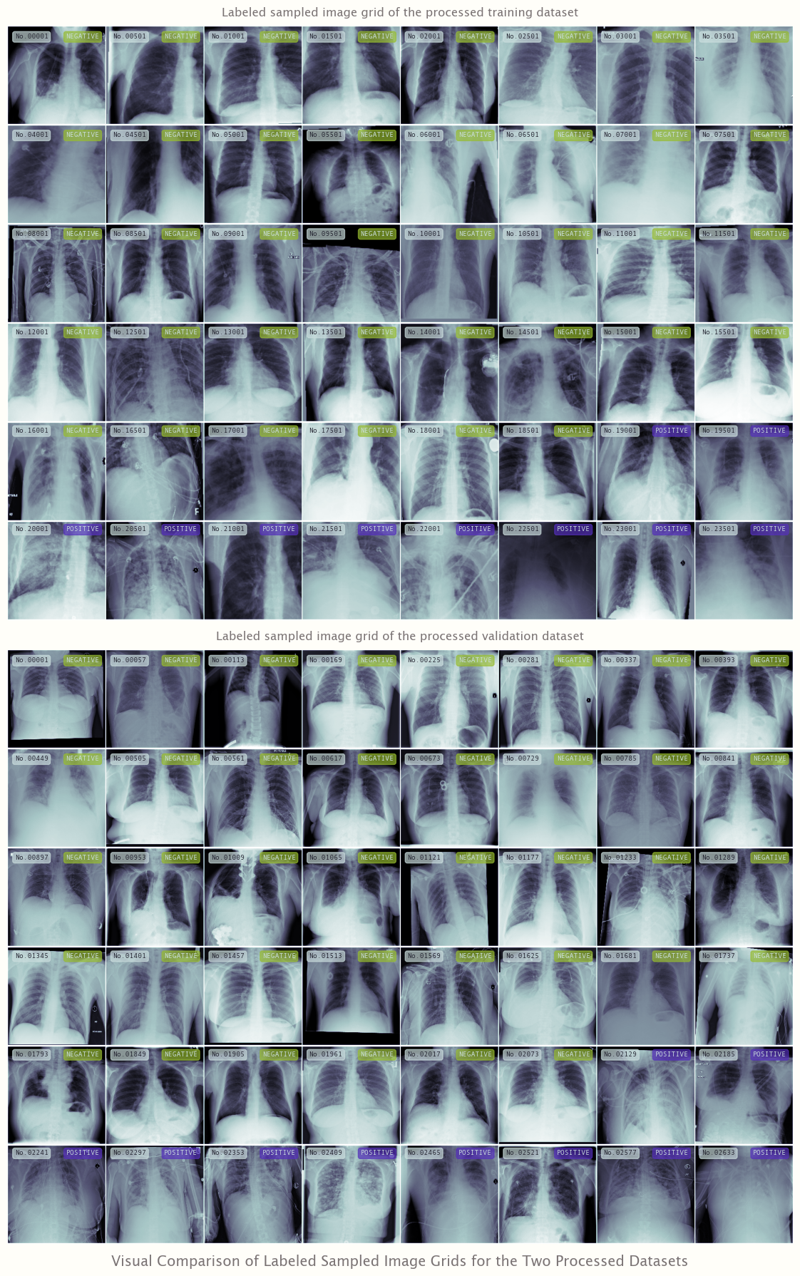

In [18]:
def annotation_color(cmap):
    cmap_color = mpl.colormaps[cmap]
    return cmap_color(0.85)


def is_pneumonia(labels):
    return ["positive" if l == 1 else "negative" for l in labels]


def title_adder(func):
    @wraps(func)
    def wrapper(inputs, ax, **kwargs):
        dataset = "training" if inputs == train_dataset else "validation"
        title = f"Labeled sampled image grid of the processed {dataset} dataset"
        func(inputs, ax, **kwargs)
        ax.set_title(
            label=title,
            loc="center",
            pad=10,
        )

    return wrapper


def grid_annotator(func):
    @wraps(func)
    def wrapper(inputs, ax, fontsize_adjustment=0, **kwargs):
        global colors
        labels, indices, positions, cmap = func(inputs, ax, **kwargs)
        x_positions_1, x_positions_2, y_positions = positions
        labels = is_pneumonia(labels)
        font_color = mpl.colormaps[cmap](0.15)
        for (y, x_1), index in zip(
            itertools.product(y_positions, x_positions_1), indices
        ):
            bbox_props = dict(
                boxstyle="round",
                ec=annotation_color(cmap),
                fc=annotation_color(cmap),
                alpha=0.67,
            )
            text = f"No.{(index + 1):>05}"
            ax.text(
                x_1,
                y,
                text,
                bbox=bbox_props,
                transform=ax.transData,
                fontsize=7 + fontsize_adjustment,
                fontfamily="monospace",
                c=font_color,
            )
        colors_dict = {"positive": colors[0], "negative": colors[1]}
        for (y, x_2), label in zip(
            itertools.product(y_positions, x_positions_2), labels
        ):
            bbox_props = dict(
                boxstyle="round",
                ec=colors_dict[label],
                fc=colors_dict[label],
                alpha=0.67,
            )
            text = f"{label}"
            ax.text(
                x_2,
                y,
                text.upper(),
                bbox=bbox_props,
                transform=ax.transData,
                fontsize=7 + fontsize_adjustment,
                fontfamily="monospace",
                c=annotation_color(cmap),
            )

    return wrapper


@title_adder
@grid_annotator
def grid_DICOM_2D_image(
    inputs, ax, n=None, row_size=8, slice_interval=500, pad_value=1
):
    if n is None:
        n = len(inputs)
    n = math.ceil(n / slice_interval)
    nrows = math.ceil(n / row_size)
    cmap = "bone"

    images, labels = [], []
    for i in range(len(inputs)):
        image, label = inputs[i]
        images.append(image)
        labels.append(label)
    # `torch.cat` concatenates the given sequence tensor by a given dimension, whose `dim`
    # parameter indicates the dimension of the concatenated tensor
    images = torch.cat(images, dim=0).unsqueeze(1)
    indices = list(range(0, len(images), slice_interval))
    images = images[::slice_interval, :, :, :]
    labels = labels[::slice_interval]

    x_positions_1 = [
        math.ceil(
            x * images[:row_size].shape[3]
            + 0.075 * images[:row_size].shape[3]
            + pad_value * x * 2
        )
        for x in range(images[:row_size].shape[0])
    ]
    x_positions_2 = [
        math.ceil(
            x * images[:row_size].shape[3]
            + 0.6 * images[:row_size].shape[3]
            + pad_value * x * 2
        )
        for x in range(images[:row_size].shape[0])
    ]
    y_positions = [
        math.ceil(
            y * images[:row_size].shape[2]
            + 0.125 * images[:row_size].shape[2]
            + pad_value * y * 3
        )
        for y in range(nrows)
    ]
    positions = [x_positions_1, x_positions_2, y_positions]

    for i in range(nrows):
        if len(images) > row_size:
            row_images = images[:row_size]
            images = images[row_size:]
        else:
            row_images = images[:]
        grid_row = make_grid(
            row_images,
            nrow=row_size,
            normalize=True,
            pad_value=pad_value,
        )
        scalar_row = grid_row.numpy().transpose(1, 2, 0)[:, :, 0]
        if i == 0:
            if nrows != 1:
                scalar_image = scalar_row
            else:
                scalar_image = np.full(
                    (
                        scalar_row.shape[0],
                        math.ceil(scalar_row.shape[1] / images.shape[0] * row_size),
                    ),
                    np.nan,
                )
                scalar_image[:, : scalar_row.shape[1]] = scalar_row
        elif scalar_image.shape[1] == scalar_row.shape[1]:
            scalar_image = np.concatenate((scalar_image, scalar_row), axis=0)
        else:
            image_to_concat = np.full(
                (scalar_image.shape[0] + scalar_row.shape[0], scalar_image.shape[1]),
                np.nan,
            )
            image_to_concat[: scalar_image.shape[0], :] = scalar_image
            image_to_concat[scalar_image.shape[0] :, : scalar_row.shape[1]] = scalar_row
            scalar_image = image_to_concat
    ax.imshow(scalar_image, cmap=cmap)
    ax.set(xticks=[], yticks=[], frame_on=False)
    ax.grid(False)
    return labels, indices, positions, cmap


colors = calm_color_generator(2)

fig, axs = plt.subplots(2, 1, figsize=(figure_size[0], figure_size[1] * 2))
grid_DICOM_2D_image(train_dataset, axs[0])
grid_DICOM_2D_image(val_dataset, axs[1], slice_interval=56)

fig.suptitle(
    "Visual Comparison of Labeled Sampled Image Grids for the Two Processed Datasets",
    fontsize="x-large",
    x=0.5,
    y=0,
)

plt.tight_layout()
plt.show()

### <a id='toc5_2_3_'></a>[Batch Loading](#toc0_)


In [19]:
torch.manual_seed(101)
batch_size = 64
num_workers = 0

# The `num_workers` parameter indicates how many child processes will be used to load the data
#
# The default value of the `num_workers` parameter is 0, indicating that the data will be
# loaded in the master process
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

tabulation = Form_Generator()
tabulation.heading_printer("Configuration for batch loading")

statements = [
    """
torch.manual_seed(101)
batch_size = 64
num_workers = 4

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False
)
"""
]
tabulation.statement_generator(statements)

expressions = [
    "len(train_loader)",
    "len(train_loader.dataset)",
    "len(val_loader)",
    "len(val_loader.dataset)",
]
results = [
    str(len(train_loader)),
    str(len(train_loader.dataset)),
    str(len(val_loader)),
    str(len(val_loader.dataset)),
]
tabulation.expression_generator(expressions, results, 12)

Configuration for batch loading

    +--------------------------------------------+
    | Statement                                  |
    +--------------------------------------------+
    | torch.manual_seed(101)                     |
    | batch_size = 64                            |
    | num_workers = 4                            |
    |                                            |
    | train_loader = DataLoader(                 |
    |     train_dataset, batch_size=batch_size,  |
    |     num_workers=num_workers, shuffle=True  |
    | )                                          |
    | val_loader = DataLoader(                   |
    |     val_dataset, batch_size=batch_size,    |
    |     num_workers=num_workers, shuffle=False |
    | )                                          |
    +--------------------------------------------+
    +---------------------------+--------+
    | Expression                | Result |
    +---------------------------+--------+
    | len(train_loader

In [20]:
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([18593,  5407]))

## <a id='toc5_3_'></a>[Train - Part Two - Model Creation](#toc0_)


In [21]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self, weight=1):
        super().__init__()

        self.model = models.resnet18()
        # change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(
            1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        # change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))

        # simple accuracy computation
        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")

    def forward(self, data):
        pred = self.model(data)
        return pred

    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = (
            label.float()
        )  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)[
            :, 0
        ]  # Prediction: Make sure prediction and label have same shape
        loss = self.loss_fn(pred, label)  # Compute the loss

        # Log loss and batch accuracy
        self.log("Train Loss", loss)
        self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))
        return loss

    def on_train_epoch_end(self):
        # After one epoch compute the whole train_data accuracy
        self.log("Train Acc", self.train_acc.compute())

    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]  # make sure prediction and label have same shape

        loss = self.loss_fn(pred, label)

        # Log validation metrics
        self.log("Val Loss", loss)
        self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
        return loss

    def on_train_epoch_end(self):
        self.log("Val Acc", self.val_acc.compute())

    def configure_optimizers(self):
        # Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]

In [22]:
model = PneumoniaModel()  # Instanciate the model

In [23]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(monitor="Val Acc", save_top_k=10, mode="max")

In [24]:
trainer = pl.Trainer(
    accelerator="mps",
    devices=1,
    logger=TensorBoardLogger(save_dir="./logs"),
    log_every_n_steps=1,
    callbacks=checkpoint_callback,
    # max_epochs=35,
    max_epochs=5,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [25]:
import warnings

warnings.filterwarnings("ignore", ".*does not have many workers.*")

In [26]:
trainer.fit(model, train_loader, val_loader)


  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.2 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | BinaryAccuracy    | 0     
3 | val_acc   | BinaryAccuracy    | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [27]:
model.parameters

<bound method Module.parameters of PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-